# AUTOMATIC MONOCULAR DEPTH ESTIMATION - DAV2

Pipeline completa per fare monocular depth estimation


### 0. Preprocessing

Già fatto grazie a /scripts/preprocess.py:
1. PARSE VIDEO METADATA
2. EXTRACT GPS DATA FROM MCAP
3. EXTRACT FRAMES AT 1 FPS WITH TIMESTAMP SYNC
4. LOAD YOLO LABELS
5. SAVE GPS CSV
6. CREATE 1 FPS VIDEO FROM EXTRACTED FRAMES

### 1. Setup and configuration

Cella per fare setup e configuration

INPUT:
- FRAMES_PATH = DATA_ROOT / "preprocessed" / f"frames_{EXP['name']}"
- VIDEO_1FPS = DATA_ROOT / "preprocessed" / f"video_1fps_{EXP['name']}.mp4"
- TARGET_CSV = DATA_ROOT / "preprocessed" / f"gps_{EXP['name']}.csv"
- CAMERA_CSV = DATA_ROOT / "preprocessed" / "camera_position.csv"
- ANCHORS_CSV = DATA_ROOT / "preprocessed" / "anchor_points.csv"

OUTPUT:
- DEPTH_OUTPUT_DIR = DATA_ROOT / f"depth_map_{ENCODER}" / "relative_{EXP['name']}"

In [1]:
# --- Cella 1: Setup & Configuration ---
import sys
from pathlib import Path

print("Step 1: Setup & Configuration")
print("=" * 60)

exp = "4"  # 1, 2, 3, 4

DATA_ROOT = Path.cwd().parent

EXPERIMENT_DICT = {
    "1": dict(video_raw="video_c_20251106_152844.mp4", mcap="gps_20251106_153635.mcap", 
              label="label_152844", name="exp1_152844"),
    "2": dict(video_raw="video_c_20251106_154149.mp4", mcap="gps_20251106_154245.mcap", 
              label="label_154149", name="exp2_154149"),
    "3": dict(video_raw="video_c_20251106_161904.mp4", mcap="gps_20251106_161835.mcap", 
              label="label_161904", name="exp3_161904"),
    "4": dict(video_raw="video_c_20251106_162533.mp4", mcap="gps_20251106_162531.mcap", 
              label="label_162533", name="exp4_162533"),
}

if exp not in EXPERIMENT_DICT:
    raise ValueError(f"Invalid experiment ID: {exp}")

EXP = EXPERIMENT_DICT[exp]

# Paths
FRAMES_PATH = DATA_ROOT / "preprocessed" / f"frames_{EXP['name']}"
TARGET_CSV = DATA_ROOT / "preprocessed" / f"gps_{EXP['name']}.csv"
VIDEO_1FPS = DATA_ROOT / "preprocessed" / f"video_1fps_{EXP['name']}.mp4"
CAMERA_CSV = DATA_ROOT / "preprocessed" / "camera_position.csv"
ANCHORS_CSV = DATA_ROOT / "preprocessed" / "anchor_points.csv"

# Output paths
DEPTH_OUTPUT_DIR = DATA_ROOT / "depth_map_dav2" / f"relative_{EXP['name']}"
DEPTH_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

RESULTS_DIR = DATA_ROOT / "result_dav2" / f"results_{EXP['name']}"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"\nExperiment: {EXP['name']}")
print(f"Data root: {DATA_ROOT}")
print(f"Frames: {FRAMES_PATH}")
print(f"Depth output: {DEPTH_OUTPUT_DIR}")
print("=" * 60)

Step 1: Setup & Configuration

Experiment: exp4_162533
Data root: /media/labust/test_ssd/pipeline
Frames: /media/labust/test_ssd/pipeline/preprocessed/frames_exp4_162533
Depth output: /media/labust/test_ssd/pipeline/depth_map_dav2/relative_exp4_162533


### 2. Load data & compute distances

In questa cella carico i file csv (anchor, target, camera), li estraggo e calcolo le distanze 3D con la formula di haversine.

In [2]:
# --- Cella 2: Data Loading & Distance Computation ---
import pandas as pd
import numpy as np
from pathlib import Path

print("\nStep 2: Data Loading & Distance Computation")
print("=" * 60)

# Load data
print("Loading data files...")
df_camera = pd.read_csv(CAMERA_CSV)
df_target = pd.read_csv(TARGET_CSV)
df_anchors = pd.read_csv(ANCHORS_CSV)

print(f"\nExperiment: {EXP['name']}")
print(f"  Target: {len(df_target)} frames ({df_target['x_pixel'].notna().sum()} visible)")
print(f"  Anchors: {len(df_anchors)} points")

# Haversine 3D distance function
def haversine_3d(lat1, lon1, alt1, lat2, lon2, alt2):
    """Calculate 3D distance between two geo points in meters."""
    R = 6371000
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    horizontal_dist = R * c
    vertical_dist = alt2 - alt1
    
    return np.sqrt(horizontal_dist**2 + vertical_dist**2)

# Compute distances
print("\nComputing distances...")
cam = df_camera.iloc[0]

distances_to_anchors = np.array([
    haversine_3d(
        cam['latitude'], cam['longitude'], cam['altitude'],
        anchor['latitude'], anchor['longitude'], anchor['altitude']
    )
    for _, anchor in df_anchors.iterrows()
])

distances_to_target = df_target.apply(
    lambda row: haversine_3d(
        cam['latitude'], cam['longitude'], cam['altitude'],
        row['latitude'], row['longitude'], row['altitude']
    ) if pd.notna(row['x_pixel']) else np.nan,
    axis=1
).values

print(f"  Anchor distances (m): {distances_to_anchors}")
print(f"  Target distance range: {np.nanmin(distances_to_target):.2f} - {np.nanmax(distances_to_target):.2f} m")
print(f"  Valid target frames: {(~np.isnan(distances_to_target)).sum()}/{len(distances_to_target)}")
print("=" * 60)


Step 2: Data Loading & Distance Computation
Loading data files...

Experiment: exp4_162533
  Target: 1039 frames (843 visible)
  Anchors: 3 points

Computing distances...
  Anchor distances (m): [45.00243707 68.16784127 65.85306792]
  Target distance range: 46.15 - 134.52 m
  Valid target frames: 843/1039


### 3. Relative Depth Estimation

In questa faccio la relativa depth estimation con DA-V2.
Posso decidere se fare l'inferenza sui frame o se caricare le depth map già calcolate in precedenza.

In [3]:
# --- Cella 3a: Import Depth Anything V2 ---
import sys
import torch
import cv2
import numpy as np
import gc
from tqdm import tqdm

print("\nStep 3a: Import Depth Anything V2")
print("=" * 60)

# Device detection
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Disabilita xformers su CPU (incompatibile)
if DEVICE == 'cpu':
    import os
    os.environ['XFORMERS_DISABLED'] = '1'
    print(" CPU detected: xformers disabled")

# Model paths
DEPTH_ANYTHING = DATA_ROOT / "models" / "Depth-Anything-V2"

if str(DEPTH_ANYTHING) not in sys.path:
    sys.path.append(str(DEPTH_ANYTHING))

from depth_anything_v2.dpt import DepthAnythingV2

# Configurazione
ENCODER = 'vits' if DEVICE == 'cpu' else 'vitl'  # Usa modello piccolo su CPU
RELOAD_DEPTH_MAPS = False

MODEL = {
    'class': DepthAnythingV2,
    'checkpoint': 'depth_anything_v2'
}

ModelClass = MODEL['class']

print(f"✓ Device: {DEVICE}")
print(f"✓ Model: Depth Anything V2 ({ENCODER})")
print(f"✓ Cache mode: {'RELOAD' if RELOAD_DEPTH_MAPS else 'COMPUTE'}")
print("=" * 60)


Step 3a: Import Depth Anything V2


xFormers not available
xFormers not available


✓ Device: cuda
✓ Model: Depth Anything V2 (vitl)
✓ Cache mode: COMPUTE


In [4]:
# --- Cella 3.b: Inference Depth Estimation (DAV2) ---
print("\nStep 3: Depth Estimation")
print("=" * 60)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Device: {DEVICE}")
print(f"Mode: {'RELOAD cached depth maps' if RELOAD_DEPTH_MAPS else 'COMPUTE depth maps'}")

MODEL_CONFIGS = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

def normalize_depth_map(depth_map):
    """Normalizza depth map a range [0, 1] per confronti universali."""
    min_val = depth_map.min()
    max_val = depth_map.max()
    
    if max_val - min_val < 1e-8:
        return np.zeros_like(depth_map)
    
    normalized = (depth_map - min_val) / (max_val - min_val)
    return normalized

def get_depth_map_scale(original_img_path, depth_map):
    """Calcola il fattore di scala tra immagine originale e depth map."""
    img = cv2.imread(str(original_img_path))
    orig_h, orig_w = img.shape[:2]
    depth_h, depth_w = depth_map.shape
    
    scale_x = depth_w / orig_w
    scale_y = depth_h / orig_h
    
    return scale_x, scale_y

def extract_depth_at_point(depth_map, x, y, scale_x=1.0, scale_y=1.0, patch_size=3):
    """Extract median depth from patch around point (con scaling)."""
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    
    h, w = depth_map.shape
    half = patch_size // 2
    
    y_start = max(0, y_scaled - half)
    y_end = min(h, y_scaled + half + 1)
    x_start = max(0, x_scaled - half)
    x_end = min(w, x_scaled + half + 1)
    
    patch = depth_map[y_start:y_end, x_start:x_end]
    return np.median(patch) if patch.size > 0 else np.nan

frame_names = df_target['frame_name'].unique()
print(f"\nProcessing {len(frame_names)} frames...")

all_cached = all(
    (DEPTH_OUTPUT_DIR / frame_name.replace('.png', '_depth.npy')).exists()
    for frame_name in frame_names
)

if RELOAD_DEPTH_MAPS and all_cached:
    print("✓ All depth maps found in cache, reloading...")
    model = None
else:
    if RELOAD_DEPTH_MAPS:
        print("  Some depth maps missing, will compute them...")
    
    print(f"Loading Depth Anything V2 ({ENCODER})...")
    model = ModelClass(**MODEL_CONFIGS[ENCODER])
    checkpoint_path = DEPTH_ANYTHING / 'checkpoints' / f"{MODEL['checkpoint']}_{ENCODER}.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    model = model.to(DEVICE).eval()
    print("Model loaded ")

depths_at_target = []
depths_at_anchors = np.zeros((len(frame_names), len(df_anchors)))

for frame_idx, frame_name in enumerate(tqdm(frame_names, desc="Processing")):
    frame_path = FRAMES_PATH / frame_name
    cache_path = DEPTH_OUTPUT_DIR / frame_name.replace('.png', '_depth.npy')
    normalized_cache_path = DEPTH_OUTPUT_DIR / frame_name.replace('.png', '_depth_normalized.npy')
    
    if normalized_cache_path.exists():
        depth_normalized = np.load(normalized_cache_path)
    else:
        if cache_path.exists():
            depth = np.load(cache_path)
        else:
            if model is None:
                raise RuntimeError(f"Model not loaded but cache missing for {frame_name}")
            
            img = cv2.imread(str(frame_path))
            if img is None:
                print(f"Warning: Cannot load {frame_name}")
                depths_at_target.append(np.nan)
                depths_at_anchors[frame_idx, :] = np.nan
                continue
            
            with torch.no_grad():
                depth = model.infer_image(img)
            
            np.save(cache_path, depth)
            del img
        
        depth_normalized = normalize_depth_map(depth)
        np.save(normalized_cache_path, depth_normalized)
        del depth
    
    scale_x, scale_y = get_depth_map_scale(frame_path, depth_normalized)
    
    target_row = df_target[df_target['frame_name'] == frame_name].iloc[0]
    if pd.notna(target_row['x_pixel']):
        depth_val = extract_depth_at_point(
            depth_normalized, 
            target_row['x_pixel'], 
            target_row['y_pixel'],
            scale_x, scale_y
        )
        depths_at_target.append(depth_val)
    else:
        depths_at_target.append(np.nan)
    
    for anchor_idx, (_, anchor) in enumerate(df_anchors.iterrows()):
        if pd.notna(anchor['x_pixel']) and pd.notna(anchor['y_pixel']):
            depth_val = extract_depth_at_point(
                depth_normalized, 
                anchor['x_pixel'], 
                anchor['y_pixel'],
                scale_x, scale_y
            )
            depths_at_anchors[frame_idx, anchor_idx] = depth_val
        else:
            depths_at_anchors[frame_idx, anchor_idx] = np.nan
    
    del depth_normalized
    
    if (frame_idx + 1) % 50 == 0:
        gc.collect()
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()

depths_at_target = np.array(depths_at_target)

if model is not None:
    del model
gc.collect()
if DEVICE == 'cuda':
    torch.cuda.empty_cache()

print(f"\n✓ Depth extraction complete:")
print(f"  Target depths: {np.nanmean(depths_at_target):.4f} ± {np.nanstd(depths_at_target):.4f}")
print(f"  Valid depths: {np.sum(~np.isnan(depths_at_target))}/{len(depths_at_target)}")
print(f"  Anchor depths shape: {depths_at_anchors.shape}")
print(f"  Cached depth maps: {DEPTH_OUTPUT_DIR}")
print(f"  Cached normalized maps: {DEPTH_OUTPUT_DIR} (*_normalized.npy)")
print("=" * 60)


Step 3: Depth Estimation
Device: cuda
Mode: COMPUTE depth maps

Processing 1039 frames...
Loading Depth Anything V2 (vitl)...
Model loaded 


Processing: 100%|██████████| 1039/1039 [08:52<00:00,  1.95it/s]


✓ Depth extraction complete:
  Target depths: 0.0578 ± 0.0300
  Valid depths: 843/1039
  Anchor depths shape: (1039, 3)
  Cached depth maps: /media/labust/test_ssd/pipeline/depth_map_dav2/relative_exp4_162533
  Cached normalized maps: /media/labust/test_ssd/pipeline/depth_map_dav2/relative_exp4_162533 (*_normalized.npy)


### 4. Metric calibration

Calibro le mappe relative in metriche usando la formula: metric = 1/(a*relative + b) e cerco i parametri ottimi a e b tramite least squares.


Step 4: Metric Calibration
Calibration samples: 3117
  Relative depth range: [0.0597, 0.1394]
  Metric distance range: [45.00m, 68.17m]

Optimal coefficients:
  a = 0.135062
  b = 0.005343

Calibration Metrics:
  RMSE: 2.75 m
  MAE:  1.92 m
  MAPE: 3.14 %


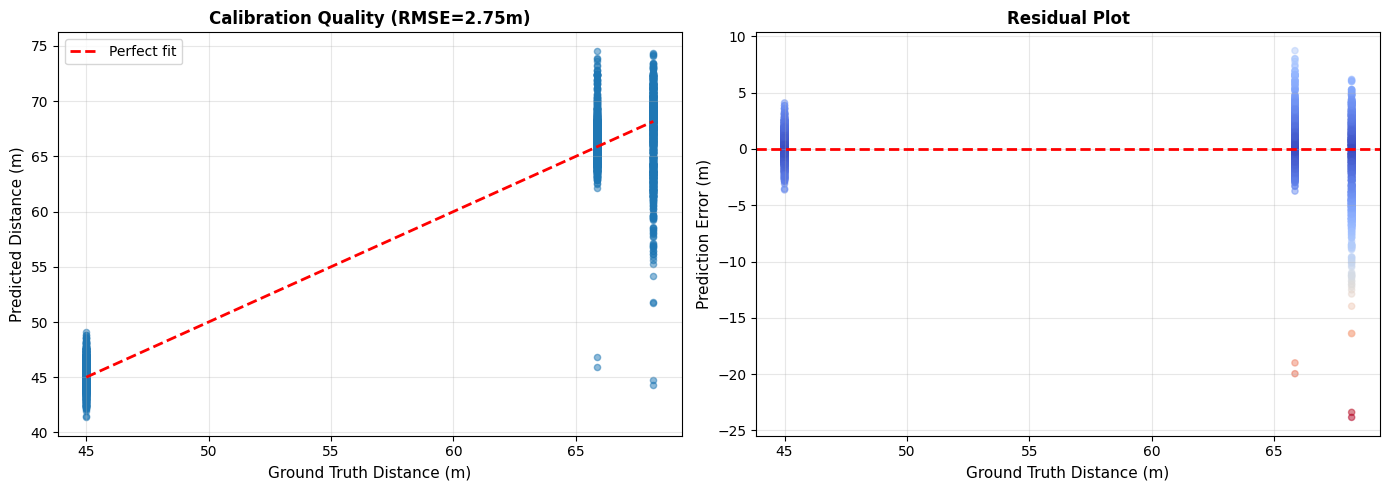


Target Prediction Metrics:
  RMSE: 10.12 m
  MAE:  7.61 m
  Valid predictions: 843/1039

✓ Calibration complete


In [5]:
# --- Cella 4: Metric Calibration (Relative → Metric) ---
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

print("\nStep 4: Metric Calibration")
print("=" * 60)

# Prepare calibration data
anchor_relative = []
anchor_metric = []

for frame_idx in range(len(depths_at_anchors)):
    for anchor_idx in range(len(distances_to_anchors)):
        rel_depth = depths_at_anchors[frame_idx, anchor_idx]
        met_dist = distances_to_anchors[anchor_idx]
        
        if not np.isnan(rel_depth) and not np.isnan(met_dist) and rel_depth > 0:
            anchor_relative.append(rel_depth)
            anchor_metric.append(met_dist)

anchor_relative = np.array(anchor_relative)
anchor_metric = np.array(anchor_metric)

print(f"Calibration samples: {len(anchor_relative)}")
print(f"  Relative depth range: [{anchor_relative.min():.4f}, {anchor_relative.max():.4f}]")
print(f"  Metric distance range: [{anchor_metric.min():.2f}m, {anchor_metric.max():.2f}m]")

# Inverse model calibration: metric = 1/(a*relative + b)
y = 1.0 / (anchor_metric + 1e-12)
X = np.vstack([anchor_relative, np.ones_like(anchor_relative)]).T

coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
a_opt, b_opt = coeffs

print(f"\nOptimal coefficients:")
print(f"  a = {a_opt:.6f}")
print(f"  b = {b_opt:.6f}")

# Conversion function
def relative_to_metric(depth_relative, a=a_opt, b=b_opt):
    """Convert relative depth to metric distance."""
    eps = 1e-12
    return 1.0 / (a * depth_relative + b + eps)

# Validation
distances_pred = relative_to_metric(anchor_relative)
errors = distances_pred - anchor_metric

rmse = np.sqrt(mean_squared_error(anchor_metric, distances_pred))
mae = mean_absolute_error(anchor_metric, distances_pred)
mape = np.mean(np.abs(errors / anchor_metric)) * 100

print(f"\nCalibration Metrics:")
print(f"  RMSE: {rmse:.2f} m")
print(f"  MAE:  {mae:.2f} m")
print(f"  MAPE: {mape:.2f} %")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Ground Truth
axes[0].scatter(anchor_metric, distances_pred, alpha=0.5, s=20)
axes[0].plot([anchor_metric.min(), anchor_metric.max()], 
             [anchor_metric.min(), anchor_metric.max()], 
             'r--', lw=2, label='Perfect fit')
axes[0].set_xlabel('Ground Truth Distance (m)', fontsize=11)
axes[0].set_ylabel('Predicted Distance (m)', fontsize=11)
axes[0].set_title(f'Calibration Quality (RMSE={rmse:.2f}m)', fontsize=12, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
axes[1].scatter(anchor_metric, errors, alpha=0.5, s=20, c=np.abs(errors), cmap='coolwarm')
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Ground Truth Distance (m)', fontsize=11)
axes[1].set_ylabel('Prediction Error (m)', fontsize=11)
axes[1].set_title('Residual Plot', fontsize=12, weight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "calibration_metrics.png", dpi=150)
plt.show()

# Apply calibration to target
target_distances_pred = np.array([
    relative_to_metric(d) if not np.isnan(d) else np.nan 
    for d in depths_at_target
])

# Validation on target
valid_mask = ~np.isnan(target_distances_pred) & ~np.isnan(distances_to_target)
if valid_mask.sum() > 0:
    target_errors = target_distances_pred[valid_mask] - distances_to_target[valid_mask]
    target_rmse = np.sqrt(np.mean(target_errors**2))
    target_mae = np.mean(np.abs(target_errors))
    
    print(f"\nTarget Prediction Metrics:")
    print(f"  RMSE: {target_rmse:.2f} m")
    print(f"  MAE:  {target_mae:.2f} m")
    print(f"  Valid predictions: {valid_mask.sum()}/{len(distances_to_target)}")

print("\n✓ Calibration complete")
print("=" * 60)

### 5. Analysis, export & video generation

In questa cella analizzo la bontà dei risultati, li salvo ed esporto ed inoltre genero un video per debug visivo.

Il video (1fps) mostra i target e gli anchor points, la loro distanza dalla camera ed la traiettoria del target (vista GPS) per confrontare visivamente.


Step 5: Analysis, Export & Video Generation

[1/5] Exporting results...
  Results saved: /media/labust/test_ssd/pipeline/result_dav2/results_exp4_162533/results_exp4_162533.csv

[2/5] Temporal analysis...


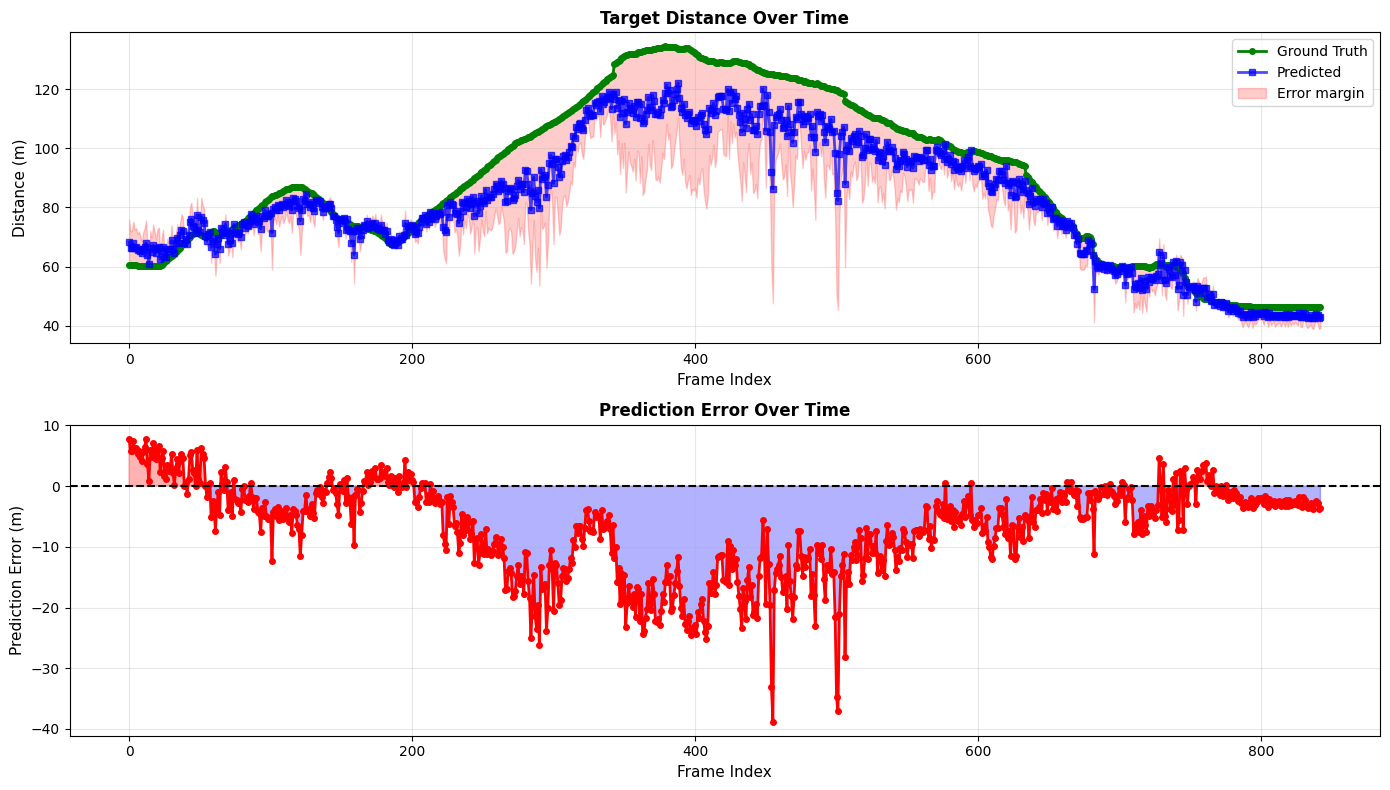

  Saved: temporal_analysis.png

[3/5] GPS trajectory visualization...


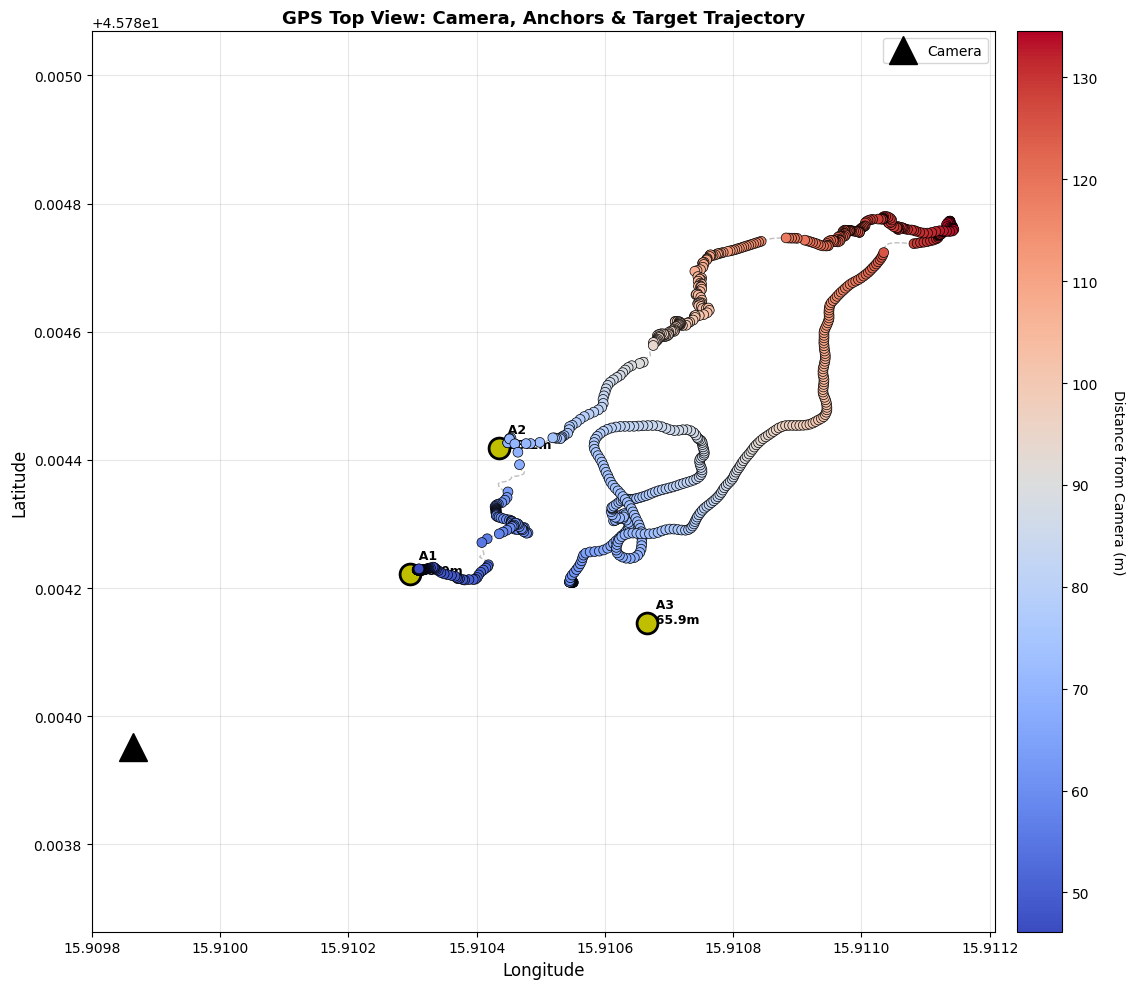

  Saved: gps_topview.png

[4/5] Error analysis...


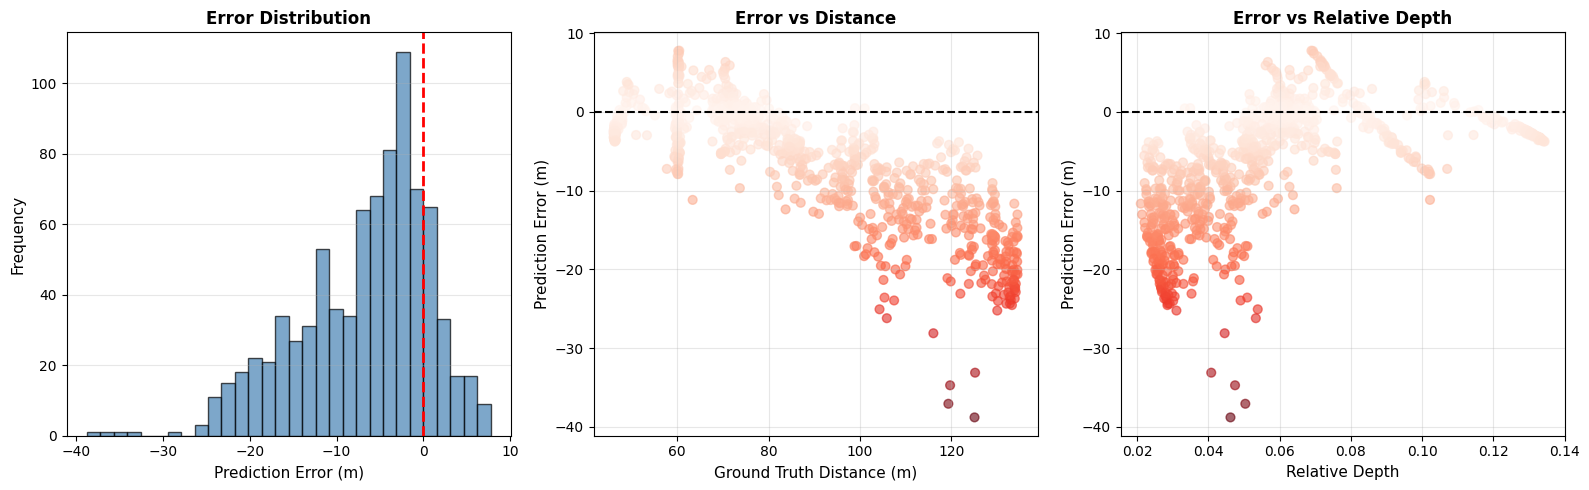

  Saved: error_analysis.png

  Error by distance range:
                  abs_error            
                       mean   std count
distance_bin                           
(46.058, 63.821]       3.04  2.05   192
(63.821, 81.496]       2.23  1.80   182
(81.496, 99.171]       6.31  3.18   151
(99.171, 116.845]     11.53  5.19   135
(116.845, 134.52]     15.93  6.09   183

[5/5] Creating annotated video...
  Input video: 1 fps, 1039 frames, 1878x996


  Generating video: 100%|██████████| 1039/1039 [01:41<00:00, 10.27it/s]

  ✓ Video saved: /media/labust/test_ssd/pipeline/result_dav2/results_exp4_162533/annotated_exp4_162533.mp4

Pipeline Complete! ✓

Experiment: exp4_162533

Outputs saved in: /media/labust/test_ssd/pipeline/result_dav2/results_exp4_162533
  - Results CSV: results_exp4_162533.csv
  - Calibration plot: calibration_metrics.png
  - Temporal analysis: temporal_analysis.png
  - GPS top view: gps_topview.png
  - Error analysis: error_analysis.png
  - Annotated video: annotated_exp4_162533.mp4

Depth maps cached in: /media/labust/test_ssd/pipeline/depth_map_dav2/relative_exp4_162533


In [6]:
# --- Cella 5: Complete Analysis & Video Generation ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg

print("\nStep 5: Analysis, Export & Video Generation")
print("=" * 60)

# ============================================================================
# 1. EXPORT RESULTS
# ============================================================================
print("\n[1/5] Exporting results...")

results_df = df_target.copy()
results_df['depth_relative'] = depths_at_target
results_df['distance_predicted'] = target_distances_pred
results_df['distance_groundtruth'] = distances_to_target
results_df['error'] = target_distances_pred - distances_to_target
results_df['abs_error'] = np.abs(results_df['error'])
results_df['percent_error'] = (results_df['error'] / results_df['distance_groundtruth']) * 100

output_csv = RESULTS_DIR / f"results_{EXP['name']}.csv"
results_df.to_csv(output_csv, index=False)
print(f"  Results saved: {output_csv}")

# ============================================================================
# 2. TEMPORAL ANALYSIS
# ============================================================================
print("\n[2/5] Temporal analysis...")

valid_results = results_df[
    results_df['distance_predicted'].notna() & 
    results_df['distance_groundtruth'].notna()
].copy()

if len(valid_results) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    frame_indices = np.arange(len(valid_results))
    
    # Distance over time
    axes[0].plot(frame_indices, valid_results['distance_groundtruth'], 
                 'o-', label='Ground Truth', color='green', linewidth=2, markersize=4)
    axes[0].plot(frame_indices, valid_results['distance_predicted'], 
                 's-', label='Predicted', color='blue', linewidth=2, markersize=4, alpha=0.7)
    axes[0].fill_between(frame_indices, 
                          valid_results['distance_predicted'] - valid_results['abs_error'],
                          valid_results['distance_predicted'] + valid_results['abs_error'],
                          alpha=0.2, color='red', label='Error margin')
    axes[0].set_xlabel('Frame Index', fontsize=11)
    axes[0].set_ylabel('Distance (m)', fontsize=11)
    axes[0].set_title('Target Distance Over Time', fontsize=12, weight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Error over time
    axes[1].plot(frame_indices, valid_results['error'], 
                 'o-', color='red', linewidth=2, markersize=4)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5)
    axes[1].fill_between(frame_indices, 0, valid_results['error'], 
                          where=(valid_results['error'] >= 0), alpha=0.3, color='red')
    axes[1].fill_between(frame_indices, 0, valid_results['error'], 
                          where=(valid_results['error'] < 0), alpha=0.3, color='blue')
    axes[1].set_xlabel('Frame Index', fontsize=11)
    axes[1].set_ylabel('Prediction Error (m)', fontsize=11)
    axes[1].set_title('Prediction Error Over Time', fontsize=12, weight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "temporal_analysis.png", dpi=150)
    plt.show()
    print(f"  Saved: temporal_analysis.png")

# ============================================================================
# 3. GPS TOP VIEW
# ============================================================================
print("\n[3/5] GPS trajectory visualization...")

fig, ax = plt.subplots(figsize=(12, 10))

cam_lat, cam_lon = df_camera.iloc[0]['latitude'], df_camera.iloc[0]['longitude']
ax.plot(cam_lon, cam_lat, 'k^', markersize=20, label='Camera', zorder=10)

# Anchors
for i, anchor in df_anchors.iterrows():
    ax.plot(anchor['longitude'], anchor['latitude'], 
            'yo', markersize=15, markeredgecolor='black', markeredgewidth=2, zorder=8)
    ax.text(anchor['longitude'], anchor['latitude'], f"  A{i+1}\n  {distances_to_anchors[i]:.1f}m",
            fontsize=9, weight='bold', ha='left')

# Target trajectory
target_valid = results_df[results_df['latitude'].notna() & results_df['longitude'].notna()]
if len(target_valid) > 0:
    scatter = ax.scatter(target_valid['longitude'], target_valid['latitude'],
                         c=target_valid['distance_groundtruth'], cmap='coolwarm',
                         s=50, edgecolors='black', linewidth=0.5, zorder=9)
    ax.plot(target_valid['longitude'], target_valid['latitude'],
            'gray', linestyle='--', linewidth=1, alpha=0.5, zorder=7)
    
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('Distance from Camera (m)', rotation=270, labelpad=20)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('GPS Top View: Camera, Anchors & Target Trajectory', fontsize=13, weight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "gps_topview.png", dpi=150)
plt.show()
print(f"  Saved: gps_topview.png")

# ============================================================================
# 4. ERROR ANALYSIS
# ============================================================================
print("\n[4/5] Error analysis...")

if len(valid_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Error distribution
    axes[0].hist(valid_results['error'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Prediction Error (m)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Error Distribution', fontsize=12, weight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    # Error vs Distance
    axes[1].scatter(valid_results['distance_groundtruth'], valid_results['error'],
                    alpha=0.6, s=40, c=valid_results['abs_error'], cmap='Reds')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5)
    axes[1].set_xlabel('Ground Truth Distance (m)', fontsize=11)
    axes[1].set_ylabel('Prediction Error (m)', fontsize=11)
    axes[1].set_title('Error vs Distance', fontsize=12, weight='bold')
    axes[1].grid(alpha=0.3)
    
    # Error vs Relative Depth
    axes[2].scatter(valid_results['depth_relative'], valid_results['error'],
                    alpha=0.6, s=40, c=valid_results['abs_error'], cmap='Reds')
    axes[2].axhline(0, color='black', linestyle='--', linewidth=1.5)
    axes[2].set_xlabel('Relative Depth', fontsize=11)
    axes[2].set_ylabel('Prediction Error (m)', fontsize=11)
    axes[2].set_title('Error vs Relative Depth', fontsize=12, weight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "error_analysis.png", dpi=150)
    plt.show()
    print(f"  Saved: error_analysis.png")
    
    # Error by distance bins
    valid_results['distance_bin'] = pd.cut(valid_results['distance_groundtruth'], bins=5)
    error_stats = valid_results.groupby('distance_bin', observed=True).agg({
        'abs_error': ['mean', 'std', 'count']
    }).round(2)
    print("\n  Error by distance range:")
    print(error_stats)

# ============================================================================
# 5. VIDEO WITH OVERLAYS
# ============================================================================
print("\n[5/5] Creating annotated video...")

# Helper functions
def create_minimap(cam_lat, cam_lon, anchors_df, target_df, current_idx, size=(350, 350)):
    """Create GPS minimap."""
    fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
    
    ax.plot(cam_lon, cam_lat, 'k^', markersize=12, label='Camera', zorder=10)
    
    for i, anchor in anchors_df.iterrows():
        ax.plot(anchor['longitude'], anchor['latitude'], 
                'yo', markersize=10, markeredgecolor='black', markeredgewidth=1.5, zorder=8)
        ax.text(anchor['longitude'], anchor['latitude'], f" A{i+1}",
                fontsize=7, weight='bold', ha='left')
    
    target_valid = target_df[
        (target_df['latitude'].notna()) & (target_df['longitude'].notna())
    ].iloc[:current_idx+1]
    
    if len(target_valid) > 0:
        ax.plot(target_valid['longitude'], target_valid['latitude'],
                'b-', linewidth=2, alpha=0.5, zorder=7)
        current = target_valid.iloc[-1]
        ax.plot(current['longitude'], current['latitude'],
                'ro', markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=9)
    
    ax.set_xlabel('Lon', fontsize=8)
    ax.set_ylabel('Lat', fontsize=8)
    ax.set_title('GPS Minimap', fontsize=9, weight='bold', pad=5)
    ax.tick_params(labelsize=6)
    ax.grid(alpha=0.3, linewidth=0.5)
    ax.legend(loc='upper right', fontsize=6, framealpha=0.9)
    ax.set_aspect('equal', adjustable='datalim')
    
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    buf = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    minimap_img = buf.reshape(canvas.get_width_height()[::-1] + (4,))
    minimap_img = cv2.cvtColor(minimap_img, cv2.COLOR_RGBA2BGR)
    minimap_img = cv2.resize(minimap_img, size)
    
    plt.close(fig)
    return minimap_img


def create_distance_overlay(target_pred, target_gt, target_err, anchor_dists, size=(400, 250)):
    """Create distance info overlay."""
    overlay = np.ones((size[1], size[0], 3), dtype=np.uint8) * 40
    
    y = 30
    
    cv2.putText(overlay, "DISTANCES", (10, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    y += 40
    cv2.line(overlay, (10, y), (size[0]-10, y), (100, 100, 100), 2)
    y += 25
    
    cv2.putText(overlay, "TARGET:", (10, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 165, 255), 2)
    y += 35
    
    if not np.isnan(target_pred):
        cv2.putText(overlay, f"  Predicted: {target_pred:.1f} m", (10, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        y += 25
        cv2.putText(overlay, f"  Ground Truth: {target_gt:.1f} m", (10, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        y += 25
        color = (0, 0, 255) if abs(target_err) > 2 else (255, 255, 0)
        cv2.putText(overlay, f"  Error: {target_err:+.1f} m", (10, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        y += 35
    else:
        cv2.putText(overlay, "  Not visible", (10, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (128, 128, 128), 1)
        y += 35
    
    cv2.putText(overlay, "ANCHORS:", (10, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    y += 35
    
    for i, dist in enumerate(anchor_dists):
        cv2.putText(overlay, f"  A{i+1}: {dist:.1f} m", (10, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        y += 25
    
    return overlay


def overlay_image(bg, overlay, x, y, alpha=0.85):
    """Overlay with transparency."""
    h, w = overlay.shape[:2]
    if y + h > bg.shape[0]:
        h = bg.shape[0] - y
        overlay = overlay[:h, :]
    if x + w > bg.shape[1]:
        w = bg.shape[1] - x
        overlay = overlay[:, :w]
    
    roi = bg[y:y+h, x:x+w]
    blended = cv2.addWeighted(roi, 1-alpha, overlay[:h, :w], alpha, 0)
    bg[y:y+h, x:x+w] = blended
    return bg


# Check if 1fps video exists
if not VIDEO_1FPS.exists():
    print(f"  Warning: 1fps video not found: {VIDEO_1FPS}")
    print(f"  Skipping video generation. Run Cella 0 first to create 1fps video.")
else:
    VIDEO_OUTPUT = RESULTS_DIR / f"annotated_{EXP['name']}.mp4"
    
    cap = cv2.VideoCapture(str(VIDEO_1FPS))
    if not cap.isOpened():
        print(f"  Error: Cannot open video {VIDEO_1FPS}")
    else:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"  Input video: {fps} fps, {total_frames} frames, {width}x{height}")
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(VIDEO_OUTPUT), fourcc, fps, (width, height))
        
        frame_names = results_df['frame_name'].tolist()
        cam_lat = df_camera.iloc[0]['latitude']
        cam_lon = df_camera.iloc[0]['longitude']
        
        frame_idx = 0
        pbar = tqdm(total=total_frames, desc="  Generating video")
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Simple 1-to-1 mapping (no skipping needed with 1fps video)
            if frame_idx < len(frame_names):
                frame_name = frame_names[frame_idx]
                frame_data = results_df[results_df['frame_name'] == frame_name]
                
                if not frame_data.empty:
                    row = frame_data.iloc[0]
                    
                    # Draw target marker
                    if pd.notna(row['x_pixel']):
                        cx, cy = int(row['x_pixel']), int(row['y_pixel'])
                        
                        bbox_size = 40
                        cv2.rectangle(frame, 
                                     (cx - bbox_size, cy - bbox_size),
                                     (cx + bbox_size, cy + bbox_size),
                                     (0, 165, 255), 3)
                        
                        cv2.drawMarker(frame, (cx, cy), (0, 165, 255), 
                                      cv2.MARKER_CROSS, 20, 2)
                        
                        cv2.putText(frame, "TARGET", (cx - 30, cy - bbox_size - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 165, 255), 2)
                    
                    # Draw anchor markers
                    for i, anchor in df_anchors.iterrows():
                        if pd.notna(anchor['x_pixel']):
                            ax, ay = int(anchor['x_pixel']), int(anchor['y_pixel'])
                            
                            cv2.circle(frame, (ax, ay), 20, (0, 255, 255), 3)
                            cv2.circle(frame, (ax, ay), 5, (0, 255, 255), -1)
                            
                            cv2.putText(frame, f"A{i+1}", (ax - 15, ay - 30),
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    
                    # Distance overlay (top-left)
                    dist_overlay = create_distance_overlay(
                        row['distance_predicted'],
                        row['distance_groundtruth'],
                        row['error'],
                        distances_to_anchors
                    )
                    frame = overlay_image(frame, dist_overlay, 20, 20, alpha=0.85)
                    
                    # Minimap (bottom-right)
                    minimap = create_minimap(
                        cam_lat, cam_lon, df_anchors, results_df, frame_idx,
                        size=(350, 350)
                    )
                    minimap_x = width - minimap.shape[1] - 20
                    minimap_y = height - minimap.shape[0] - 20
                    frame = overlay_image(frame, minimap, minimap_x, minimap_y, alpha=0.85)
            
            out.write(frame)
            frame_idx += 1
            pbar.update(1)
        
        pbar.close()
        cap.release()
        out.release()
        
        print(f"  ✓ Video saved: {VIDEO_OUTPUT}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 60)
print("Pipeline Complete! ✓")
print("=" * 60)
print(f"\nExperiment: {EXP['name']}")
print(f"\nOutputs saved in: {RESULTS_DIR}")
print(f"  - Results CSV: results_{EXP['name']}.csv")
print(f"  - Calibration plot: calibration_metrics.png")
print(f"  - Temporal analysis: temporal_analysis.png")
print(f"  - GPS top view: gps_topview.png")
print(f"  - Error analysis: error_analysis.png")
print(f"  - Annotated video: annotated_{EXP['name']}.mp4")
print(f"\nDepth maps cached in: {DEPTH_OUTPUT_DIR}")
print("=" * 60)

In [7]:
# --- Cella 5b: Depth Map Visualization Video ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

print("\nStep 5b: Depth Map Visualization Video")
print("=" * 60)

# Configuration
VIDEO_OUTPUT = RESULTS_DIR / f"depth_visualization_{EXP['name']}.mp4"
COLORMAP = 'turbo'  # Options: 'turbo', 'viridis', 'plasma', 'magma', 'jet'

if not VIDEO_1FPS.exists():
    print(f"  Warning: 1fps video not found: {VIDEO_1FPS}")
else:
    cap = cv2.VideoCapture(str(VIDEO_1FPS))
    if not cap.isOpened():
        print(f"  Error: Cannot open video")
    else:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Create side-by-side video (RGB | Depth)
        output_width = width * 2
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(VIDEO_OUTPUT), fourcc, fps, (output_width, height))
        
        frame_names = results_df['frame_name'].tolist()
        
        print(f"  Creating depth visualization video...")
        print(f"  Output size: {output_width}x{height}")
        
        pbar = tqdm(total=total_frames, desc="  Processing")
        
        frame_idx = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_idx < len(frame_names):
                frame_name = frame_names[frame_idx]
                cache_path = DEPTH_OUTPUT_DIR / frame_name.replace('.png', '_depth.npy')
                
                if cache_path.exists():
                    # Load depth map
                    depth = np.load(cache_path)
                    
                    # Normalize depth for visualization
                    depth_normalized = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
                    
                    # Apply colormap
                    cmap = cm.get_cmap(COLORMAP)
                    depth_colored = (cmap(depth_normalized)[:, :, :3] * 255).astype(np.uint8)
                    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR)
                    
                    # Get frame data for annotations
                    frame_data = results_df[results_df['frame_name'] == frame_name]
                    
                    if not frame_data.empty:
                        row = frame_data.iloc[0]
                        
                        # Draw markers on both frames
                        for img in [frame, depth_colored]:
                            # Target
                            if pd.notna(row['x_pixel']):
                                cx, cy = int(row['x_pixel']), int(row['y_pixel'])
                                cv2.circle(img, (cx, cy), 8, (0, 165, 255), -1)
                                cv2.circle(img, (cx, cy), 12, (255, 255, 255), 2)
                                
                                # Distance label
                                if pd.notna(row['distance_predicted']):
                                    label = f"{row['distance_predicted']:.1f}m"
                                    cv2.putText(img, label, (cx + 15, cy - 10),
                                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                                               (255, 255, 255), 2)
                            
                            # Anchors
                            for i, anchor in df_anchors.iterrows():
                                if pd.notna(anchor['x_pixel']):
                                    ax, ay = int(anchor['x_pixel']), int(anchor['y_pixel'])
                                    cv2.circle(img, (ax, ay), 8, (0, 255, 255), -1)
                                    cv2.circle(img, (ax, ay), 12, (0, 0, 0), 2)
                                    cv2.putText(img, f"A{i+1}", (ax - 10, ay - 15),
                                               cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                               (255, 255, 255), 2)
                    
                    # Add labels
                    cv2.putText(frame, "RGB", (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    cv2.putText(depth_colored, "DEPTH", (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    
                    # Concatenate side-by-side
                    combined = np.hstack([frame, depth_colored])
                else:
                    # No depth map available, just duplicate RGB
                    combined = np.hstack([frame, frame])
            else:
                combined = np.hstack([frame, frame])
            
            out.write(combined)
            frame_idx += 1
            pbar.update(1)
        
        pbar.close()
        cap.release()
        out.release()
        
        print(f"  ✓ Depth visualization video saved: {VIDEO_OUTPUT}")

print("=" * 60)


Step 5b: Depth Map Visualization Video
  Creating depth visualization video...
  Output size: 3756x996


  Processing:   0%|          | 0/1039 [00:00<?, ?it/s]/tmp/ipykernel_20707/442044997.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(COLORMAP)
  Processing: 100%|██████████| 1039/1039 [00:57<00:00, 18.03it/s]

  ✓ Depth visualization video saved: /media/labust/test_ssd/pipeline/result_dav2/results_exp4_162533/depth_visualization_exp4_162533.mp4
